In [ ]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import Image, display_png
from gensim.models import word2vec, KeyedVectors
from keras.models import Sequential
from keras.layers import Input, Embedding, Dense, Dropout, Flatten, GlobalAveragePooling1D,Conv1D
from keras.utils import to_categorical, plot_model, pad_sequences
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
!gdown 1hi4wVX7EXyNNLU0V-DRD6h2b4YwsLnM5

Downloading...
From: https://drive.google.com/uc?id=1hi4wVX7EXyNNLU0V-DRD6h2b4YwsLnM5
To: /content/wongnai-data.zip
100% 15.1M/15.1M [00:00<00:00, 142MB/s]


In [ ]:
!unzip wongnai-data.zip

Archive:  wongnai-data.zip
  inflating: wongnai-dev.csv         
  inflating: wongnai-test.csv        
  inflating: wongnai-train.csv       


In [ ]:
import pandas as pd
#load data
train = pd.read_csv('wongnai-train.csv', encoding='utf-8')
dev = pd.read_csv('wongnai-dev.csv', encoding='utf-8')

# show data
train

,star,tokenized
0,5,มา|ตามคำแนะนำ|จาก|เพจ| |kin| |dee| |by| |praew...
1,5,บรรยากาศ|ร้าน|น่า|นั่ง|สไตล์|ญี่ปุ่น| |อาหาร|อ...
2,5,หน้า|ร้าน|เล็ก|ๆ| |แต่|เข้าไป|มี|พื้นที่|พอสมค...
3,4,It|'|s| |really| |good| |that| |After| |You| |...
4,3,มา|ทาน|ร้าน|นี้|ตั้งแต่|ร้าน|ยัง|ไม่|มี|ห้อง|แ...
...,...,...
23995,3,สาขา|ฟิวเจอร์|รังสิต| |วันอาทิตย์|คน|เยอะ|มาก|...
23996,4,ติ๋ม|ซำ|หลากหลาย|หน้า| |ชิ้น|ค่อนข้าง|เล็ก| |ร...
23997,5,ขับ|มา|ระหว่างทาง|จาก|ระยอง|จะ|ไป|จังหวัด|จันท...
23998,4,ร้าน|นี้|ตั้งอยู่|ริมถนน|พระราม| |3| |จะ|อยู่...


In [ ]:
# Add a new column called "length" to the train and dev DataFrames, which contains the number of tokens in each review.
train['length'] = train['tokenized'].apply(lambda x: x.count('|'))
dev['length'] = dev['tokenized'].apply(lambda x: x.count('|'))
dev

,star,tokenized,length
0,4,ร้าน|เล็ก|ๆ|ตกแต่ง|น่ารัก|สไตล์|ญี่ปุ่น| |อยู่...,65
1,4,แวะ|ไป|ชม|งาน|ครบรอบ| |150| |ปี| |สมเด็จ|พระพั...,466
2,3,ร้าน|ข้าวหมูแดง|สี|มรกต|เจ้าเก่า|จาก|เยาวราช| ...,231
3,3,ร้าน| |Food| |Truck| |อาหาร|ญี่ปุ่น|ชื่อดัง| |...,123
4,3,ร้าน|นี้|เส้น|เขา|อร่อย|มาก|เลย|คะ| |นุ่ม|หนึบ...,236
...,...,...,...
7995,2,วันนี้|ก็|เหมือนเคย| |กะ|ไป|ทานข้าว|เจ้าประจำ|...,151
7996,3,รีวิว|อัน|แรก|ก็|ต้อง|ด่า|ซะ|แล้ว| |\n|สำหรับ|...,175
7997,4,ร้าน|laduree| |ใน|london| |มี|ด้วยกัน|2| |สาขา...,696
7998,3,มื้อ|กลางวัน|วันนี้| |เรา|แวะ|มา|ทาน|ที่| |Je...,153


In [ ]:
train.length.describe()

count    24000.000000
mean       161.704833
std        165.658685
min          7.000000
25%         74.000000
50%        110.000000
75%        183.000000
max       5486.000000
Name: length, dtype: float64

In [ ]:
!gdown 157SHMUysLZpa2D3o3C8uvdKmF85tnNPx

Downloading...
From: https://drive.google.com/uc?id=157SHMUysLZpa2D3o3C8uvdKmF85tnNPx
To: /content/TNC_embeddings-50.bin
100% 13.6M/13.6M [00:00<00:00, 26.2MB/s]


In [ ]:
w2v_model = KeyedVectors.load_word2vec_format("TNC_embeddings-50.bin",binary=True, unicode_errors='ignore')

In [ ]:
vocab_size = len(w2v_model.index_to_key)
print('vocab size: ', vocab_size)

vector_dim = len(w2v_model['ไป'])
print('vocab dimension: ', vector_dim)

vocab size:  61631
vocab dimension:  50


In [ ]:
# make weight matrix of word embedding, vocab size + 1 (for padding)
embedding_matrix = np.zeros((vocab_size+1, vector_dim), dtype="float32")
embedding_matrix[0] = np.zeros(vector_dim)

word_to_index = {word:i+1 for i, word in enumerate(w2v_model.index_to_key)}

# word to index dictionary, 0 for padding, UNKNOWN
word_to_index['PADDING'] = 0

for i, word in enumerate(w2v_model.index_to_key):
  if word is not None:
    embedding_matrix[i+1] = w2v_model[word]

In [ ]:
word_to_index['ไป']

15

In [ ]:
def convert_words (df, word_to_index, max_length):
  tokens = df['tokenized'].apply(lambda x: x.split('|'))
  list_of_list_of_indices = list (tokens.map(lambda x: [word_to_index.get(word, 0) for word in x]))
  return pad_sequences(list_of_list_of_indices, max_length, padding='post', value=0, truncating='post')

#max length (กำหนดเอง)
max_len = 500
train_x = convert_words (train, word_to_index, max_len)
dev_x = convert_words (dev, word_to_index, max_len)

In [ ]:
train_x[0]

array([   17,     0,    25, 10459,     0,     0,     0,     0,     0,
        3970,     0,     0,     0,     2,    77,   273,    11,  1109,
         123,  9631,     0,   123,    36,  1571,  2797,    14,    36,
          17,     0, 12663,     0,  1944,     0,     0,     0, 11200,
           0,    35,  1606,  4983,     0,     2, 10459,  1132,     7,
       45943,  3000,    22,    12,    37, 14804,     0,   672,  1004,
          30,   101,   335,     0,     0,     0,     0,  1022,  7425,
         272,     0,   325,     0,    15,  3954,     0,   698,   885,
           0, 12663,     0,  1944,     0,  3665,    22,     0,   197,
         198,    15,     4,   380,     0,     5,  1841,   257,   628,
         816,    22,     0,   598,   567,     0,   402,    63,    22,
           0,     0,   257,    32,     2,     0,     0, 11200,     0,
           0,  4003,   476,    22,     0,    53,     0, 12482,     0,
           5,    70,     0,     0,  4003,  1301,   298,     0,   381,
           0, 17353,

In [ ]:
def get_label(d):
  star_to_label = {1:0, 2:0, 3:1, 4:2, 5:2}
  # apply functions & convert to mp.array
  label = np.array(d['label'].replace(star_to_label).tolist())
  d['label'] = label
  return to_categorical(label, num_classes=3)

#label one-hot vector
train_y = get_label(train)
dev_y = get_label(dev)

NameError: ignored

In [ ]:
train_y[0:10]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
# check the shape
print('input train: ', train_x.shape)
print('input dev: ', dev_x.shape)
print('label train: ', train_y.shape)
print('label dev: ', dev_y.shape)

input train:  (24000, 500)
input dev:  (8000, 500)
label train:  (24000, 3)
label dev:  (8000, 3)


##Feedforward

In [ ]:
#instantiation
model = Sequential()

# add embedding layer
model.add(Embedding (input_dim=vocab_size+1,
                     input_length=max_len,
                     output_dim=vector_dim,
                     weights=[embedding_matrix],
                     mask_zero=True,
                     trainable=False))

# average
model.add(GlobalAveragePooling1D())

# add hidden layer
model.add(Dense (150, activation='relu'))

# add output layer
model.add(Dense (3, activation='softmax'))

# complile model
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 50)           3081600   
                                                                 
 global_average_pooling1d (  (None, 50)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 150)               7650      
                                                                 
 dense_1 (Dense)             (None, 3)                 453       
                                                                 
Total params: 3089703 (11.79 MB)
Trainable params: 8103 (31.65 KB)
Non-trainable params: 3081600 (11.76 MB)
_________________________________________________________________


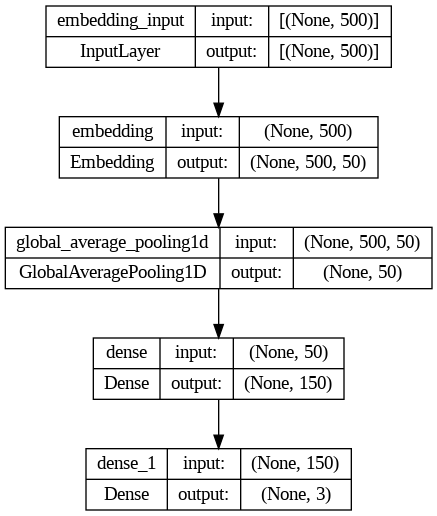

In [ ]:
plot_model(model,show_shapes=True,to_file='model.png')
display_png(Image('model.png'))

In [ ]:
history = model.fit(train_x,train_y,batch_size=128,epochs=10,validation_data=(dev_x,dev_y))

Epoch 1/10
188/188 [==============================] - 3s 14ms/step - loss: 0.7843 - accuracy: 0.6393 - val_loss: 0.7808 - val_accuracy: 0.6370
Epoch 2/10
188/188 [==============================] - 2s 12ms/step - loss: 0.7592 - accuracy: 0.6450 - val_loss: 0.7608 - val_accuracy: 0.6410
Epoch 3/10
188/188 [==============================] - 3s 16ms/step - loss: 0.7527 - accuracy: 0.6472 - val_loss: 0.7585 - val_accuracy: 0.6440
Epoch 4/10
188/188 [==============================] - 4s 23ms/step - loss: 0.7498 - accuracy: 0.6490 - val_loss: 0.7659 - val_accuracy: 0.6434
Epoch 5/10
188/188 [==============================] - 2s 12ms/step - loss: 0.7461 - accuracy: 0.6499 - val_loss: 0.7878 - val_accuracy: 0.6041
Epoch 6/10
188/188 [==============================] - 2s 12ms/step - loss: 0.7451 - accuracy: 0.6505 - val_loss: 0.7613 - val_accuracy: 0.6438
Epoch 7/10
188/188 [==============================] - 3s 13ms/step - loss: 0.7427 - accuracy: 0.6519 - val_loss: 0.7693 - val_accuracy: 0.6403

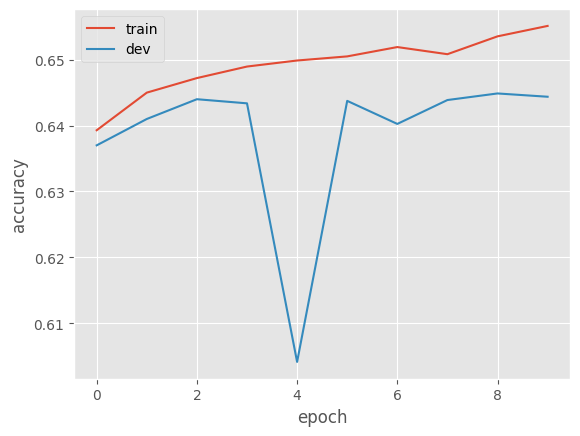

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

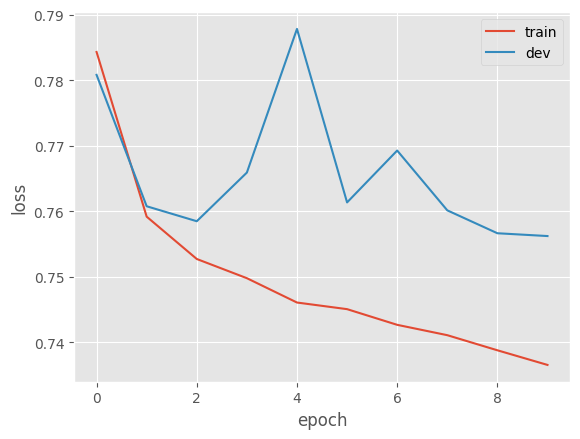

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

In [ ]:
prediction = [np.argmax(x) for x in model.predict(dev_x)]
print(classification_report(dev['label'], prediction))

250/250 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.40      0.11      0.17       452
           1       0.46      0.18      0.25      2449
           2       0.67      0.92      0.78      5099

    accuracy                           0.64      8000
   macro avg       0.51      0.40      0.40      8000
weighted avg       0.59      0.64      0.58      8000

